<a href="https://www.kaggle.com/code/shreyasudaya/math-unlearning?scriptVersionId=213371184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader, Subset
from collections import OrderedDict
from copy import deepcopy
from matplotlib import pyplot as plt
from PIL import Image
import numpy as n
import torch.optim as optim
import random
from tqdm import tqdm
import seaborn as sns
import os

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter dataset
def get_filtered_dataset(dataset, excluded_class):
    indices = [i for i, (_, label) in enumerate(dataset) if label != excluded_class]
    return Subset(dataset, indices)

100%|██████████| 170498071/170498071 [00:02<00:00, 60437541.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
from torch.utils.data import Dataset

class RemappedDataset(Dataset):
    def __init__(self, subset, excluded_class):
        self.subset = subset
        self.excluded_class = excluded_class
        self.label_map = self._create_label_map()

    def _create_label_map(self):
        """Create a mapping from original labels to new labels."""
        labels = [label for _, label in self.subset]
        unique_labels = sorted(set(labels) - {self.excluded_class})
        return {original: new for new, original in enumerate(unique_labels)}

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        data, label = self.subset[idx]
        return data, self.label_map[label]

# Update filtered dataset creation
def get_filtered_and_remapped_dataset(dataset, excluded_class):
    indices = [i for i, (_, label) in enumerate(dataset) if label != excluded_class]
    filtered_subset = Subset(dataset, indices)
    return RemappedDataset(filtered_subset, excluded_class)



In [4]:
def train_resnet(model, train_loader, epochs=10, device="cuda"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}")
    
    return model

# Extract and stack weight matrices

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18 on all classes
model_all = models.resnet18(num_classes=10)  # Adjust for CIFAR-10
train_loader_all = DataLoader(train_dataset, batch_size=64, shuffle=True)
trained_model_all = train_resnet(model_all, train_loader_all, device=device)

filtered_dataset = get_filtered_and_remapped_dataset(train_dataset, excluded_class=0)
train_loader_filtered = DataLoader(filtered_dataset, batch_size=64, shuffle=True)
model_filtered = models.resnet18(num_classes=9)  # Adjust for 9 classes
trained_model_filtered = train_resnet(model_filtered, train_loader_filtered, device=device)



Epoch 1/10, Loss: 1078.3195
Epoch 2/10, Loss: 766.8092
Epoch 3/10, Loss: 638.2824
Epoch 4/10, Loss: 539.3869
Epoch 5/10, Loss: 462.2761
Epoch 6/10, Loss: 388.7503
Epoch 7/10, Loss: 324.5574
Epoch 8/10, Loss: 263.8375
Epoch 9/10, Loss: 213.6282
Epoch 10/10, Loss: 173.1837
Epoch 1/10, Loss: 924.3583
Epoch 2/10, Loss: 672.1028
Epoch 3/10, Loss: 550.8018
Epoch 4/10, Loss: 465.1259
Epoch 5/10, Loss: 400.5302
Epoch 6/10, Loss: 335.7382
Epoch 7/10, Loss: 280.8149
Epoch 8/10, Loss: 235.4319
Epoch 9/10, Loss: 188.3947
Epoch 10/10, Loss: 154.5905


In [6]:
# Stack weight matrices
def get_activations(model):
    act = []
    bi = []
    for name, param in model.named_parameters():
        if 'weight' in name and len(param.shape)<=2:
            act.append(param.clone().detach().cpu().numpy())
        elif 'bias' in name:
            bi.append(param.clone().detach().cpu().numpy())
        
    return act,bi

weights_all,bias_all = get_activations(trained_model_all)
weights_filtered,bias_filtered = get_activations(trained_model_filtered)

# Stack the weights from both models
#stacked_weights = [torch.stack([w_all, w_filtered]) for w_all, w_filtered in zip(weights_all, weights_filtered)]

# Print shapes of stacked weights
for i, weights in enumerate(weights_all):
    print(f"Layer {i + 1}, Stacked Weight Shape: {weights.shape}")

for i, weights in enumerate(weights_filtered):
    print(f"Layer {i + 1}, Stacked Weight Shape: {weights.shape}")

Layer 1, Stacked Weight Shape: (64,)
Layer 2, Stacked Weight Shape: (64,)
Layer 3, Stacked Weight Shape: (64,)
Layer 4, Stacked Weight Shape: (64,)
Layer 5, Stacked Weight Shape: (64,)
Layer 6, Stacked Weight Shape: (128,)
Layer 7, Stacked Weight Shape: (128,)
Layer 8, Stacked Weight Shape: (128,)
Layer 9, Stacked Weight Shape: (128,)
Layer 10, Stacked Weight Shape: (128,)
Layer 11, Stacked Weight Shape: (256,)
Layer 12, Stacked Weight Shape: (256,)
Layer 13, Stacked Weight Shape: (256,)
Layer 14, Stacked Weight Shape: (256,)
Layer 15, Stacked Weight Shape: (256,)
Layer 16, Stacked Weight Shape: (512,)
Layer 17, Stacked Weight Shape: (512,)
Layer 18, Stacked Weight Shape: (512,)
Layer 19, Stacked Weight Shape: (512,)
Layer 20, Stacked Weight Shape: (512,)
Layer 21, Stacked Weight Shape: (10, 512)
Layer 1, Stacked Weight Shape: (64,)
Layer 2, Stacked Weight Shape: (64,)
Layer 3, Stacked Weight Shape: (64,)
Layer 4, Stacked Weight Shape: (64,)
Layer 5, Stacked Weight Shape: (64,)
Layer 6

In [13]:
for i, weights in enumerate(bias_all):
    print(f"Layer {i + 1}, Stacked Weight Shape: {weights.shape}")

print(bias_all[20])

Layer 1, Stacked Weight Shape: (64,)
Layer 2, Stacked Weight Shape: (64,)
Layer 3, Stacked Weight Shape: (64,)
Layer 4, Stacked Weight Shape: (64,)
Layer 5, Stacked Weight Shape: (64,)
Layer 6, Stacked Weight Shape: (128,)
Layer 7, Stacked Weight Shape: (128,)
Layer 8, Stacked Weight Shape: (128,)
Layer 9, Stacked Weight Shape: (128,)
Layer 10, Stacked Weight Shape: (128,)
Layer 11, Stacked Weight Shape: (256,)
Layer 12, Stacked Weight Shape: (256,)
Layer 13, Stacked Weight Shape: (256,)
Layer 14, Stacked Weight Shape: (256,)
Layer 15, Stacked Weight Shape: (256,)
Layer 16, Stacked Weight Shape: (512,)
Layer 17, Stacked Weight Shape: (512,)
Layer 18, Stacked Weight Shape: (512,)
Layer 19, Stacked Weight Shape: (512,)
Layer 20, Stacked Weight Shape: (512,)
Layer 21, Stacked Weight Shape: (10,)
[-0.00078885  0.01411792 -0.01819126  0.07915631  0.05230501  0.05593003
 -0.03336216 -0.00669605  0.01038504  0.00101756]


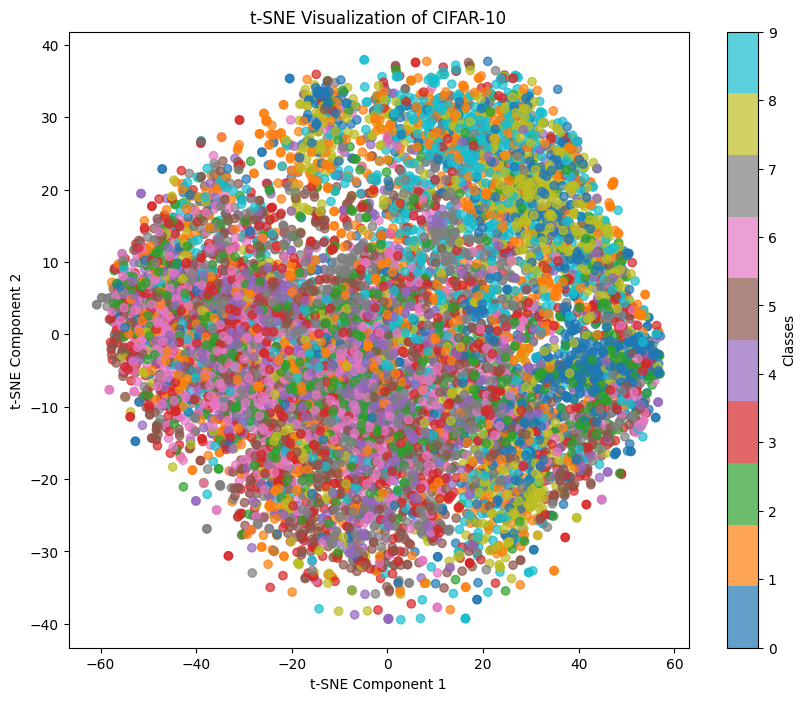

In [34]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
n_samples = 10000
data, labels = zip(*[(train_dataset[i][0].numpy(), train_dataset[i][1]) for i in range(n_samples)])
data = np.array(data)
labels = np.array(labels)

# Flatten the images
data_flattened = data.reshape(data.shape[0], -1)

# Standardize the data (important for t-SNE)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_flattened)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_tsne = tsne.fit_transform(data_scaled)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Classes')
plt.title('t-SNE Visualization of CIFAR-10')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

Files already downloaded and verified


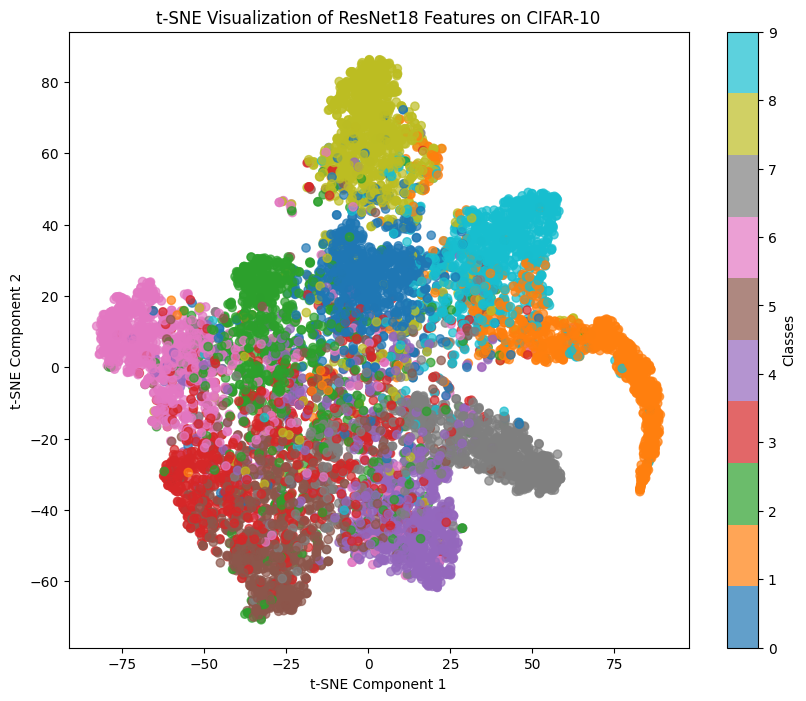

In [38]:
def extract_features(model, dataloader):
    features = []
    labels = []

    def hook_fn(module, input, output):
        features.append(output.detach().cpu())

    handle = model.avgpool.register_forward_hook(hook_fn)

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            _ = model(images)
            labels.extend(targets.numpy())

    handle.remove()
    features = torch.cat(features).view(len(labels), -1).numpy()  # Flatten features
    return features, np.array(labels)
cifar10 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(cifar10, batch_size=512, shuffle=False)
features, labels = extract_features(trained_model_all, dataloader)


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_features = tsne.fit_transform(features)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Classes')
plt.title('t-SNE Visualization of ResNet18 Features on CIFAR-10')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


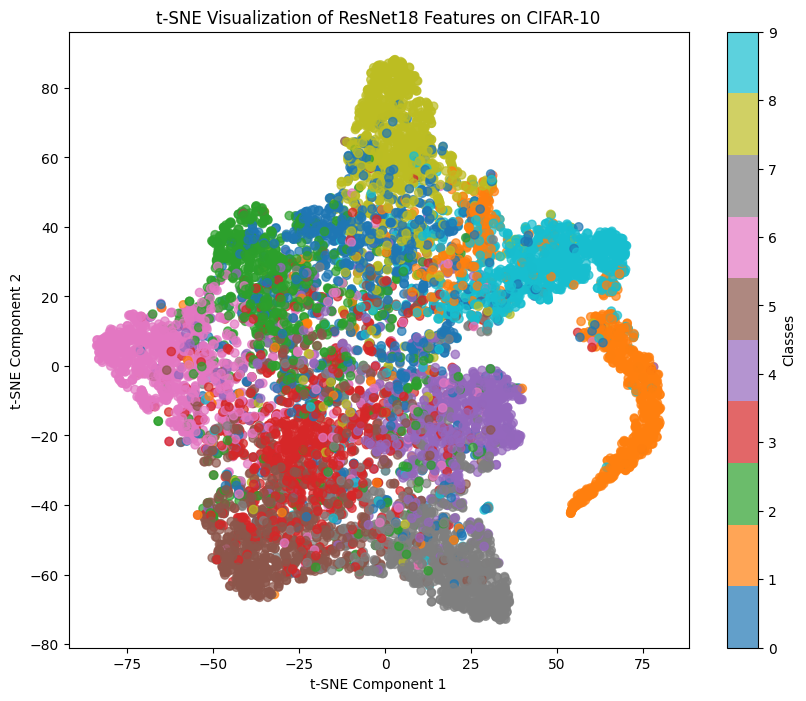

In [39]:
features, labels = extract_features(trained_model_filtered, dataloader)


tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_features = tsne.fit_transform(features)


plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Classes')
plt.title('t-SNE Visualization of ResNet18 Features on CIFAR-10')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()